In [40]:
import re
import numpy as np
import pandas as pd
import tqdm
import math

##Imports for gensim, Machine Learning LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

##Imports for NLP
import spacy
import nltk
from nltk.corpus import stopwords
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(filename='gensim.log',format="%(asctime)s:%(levelname)s:%(message)s",level=logging.INFO)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [3]:
# NLTK Stop words
# stop_words = stopwords.words('english')

nltk.download('words')
words = set(nltk.corpus.words.words())

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [4]:
email_dataset = pd.read_csv("../csv-dataset/custom_email_dataset.csv") 
email_dataset.head()

,DateTime,From,To,Subject,Message_body
0,2021-04-16 11:34:34+00:00,Quincy Larson <quincy@freecodecamp.org>,malvisbid@gmail.com,Learn how to code video games [free 7-hour Uni...,[<p>Here are this week's five links that are w...
1,2021-04-09 19:15:54+00:00,Quincy Larson <quincy@freecodecamp.org>,malvisbid@gmail.com,Two free Python courses for you this week – Dj...,[<p>Here are this week's five links that are w...
2,2021-04-02 14:59:32+00:00,Quincy Larson <quincy@freecodecamp.org>,malvisbid@gmail.com,Learn to code APIs using Node.js [free 8-hour ...,[<p>Here are this week's five links that are w...
3,2021-03-26 17:00:08+00:00,Quincy Larson <quincy@freecodecamp.org>,malvisbid@gmail.com,40 JavaScript project ideas so you can learn b...,[<p>Here are this week's five links that are w...
4,2021-03-19 17:27:22+00:00,Quincy Larson <quincy@freecodecamp.org>,malvisbid@gmail.com,Learn Data Structures and Algorithms [free 6-h...,[<p>Here are this week's five links that are w...


In [7]:
email_bodies=email_dataset.drop(['DateTime','From','To','Subject'], axis = 1)
email_bodies.head()

,Message_body
0,[<p>Here are this week's five links that are w...
1,[<p>Here are this week's five links that are w...
2,[<p>Here are this week's five links that are w...
3,[<p>Here are this week's five links that are w...
4,[<p>Here are this week's five links that are w...


In [8]:
# Convert to list
data = email_bodies.Message_body
pprint(data[:1])


0    [<p>Here are this week's five links that are w...
Name: Message_body, dtype: object


In [11]:
# Using regex expressions to get rid of distractions
# Remove <p> and</p> tags
data = [re.sub("<p[^>]*>", "", sent) for sent in data]
data = [re.sub("</?p[^>]*>", "", sent) for sent in data]

# Remove non alphanumeric and underscore values
data = [re.sub(r'[^\w]', ' ', sent) for sent in data]

print(data[:1])

[' Here are this week s five links that are worth your time     1  Building video games can be just as much fun as playing them  And this in depth Unity 3D course for beginners will show you how to get started as a game developer  You ll learn how to install Unity  program game physics  animate your characters  code your enemy AI  and more   7 hour YouTube course   https   www freecodecamp org news game development for beginners unity course     2  As of 2021  more than 40  of all websites use WordPress  It s a relatively easy tool for building blogs  ecommerce sites  and more elaborate applications as well  This free course will show you how to host a WordPress site on the web  add custom features through plugins  and design it to look however you want   2 hour YouTube course   https   www freecodecamp org news how to make a website with wordpress     3  You may have heard about the branch of science called Game Theory  This tutorial will show you how Evolutionary Game Theory works in

In [13]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
pprint(data_words)

  'https',
  'www',
  'freecodecamp',
  'org',
  'ue',
  'ystttlxqo',
  'nnegosgnvb'],
 ['here',
  'are',
  'this',
  'week',
  'five',
  'links',
  'that',
  'are',
  'worth',
  'your',
  'time',
  'learn',
  'back',
  'end',
  'development',
  'with',
  'node',
  'js',
  'and',
  'express',
  'using',
  'this',
  'free',
  'in',
  'depth',
  'course',
  'hour',
  'watch',
  'https',
  'www',
  'freecodecamp',
  'org',
  'news',
  'learn',
  'express',
  'js',
  'in',
  'this',
  'complete',
  'course',
  'kevin',
  'got',
  'his',
  'first',
  'job',
  'as',
  'web',
  'developer',
  'when',
  'he',
  'was',
  'years',
  'old',
  'he',
  'shares',
  'his',
  'advice',
  'for',
  'how',
  'you',
  'can',
  'learn',
  'to',
  'code',
  'and',
  'get',
  'developer',
  'job',
  'too',
  'minute',
  'read',
  'https',
  'www',
  'freecodecamp',
  'org',
  'forum',
  'from',
  'es',
  'to',
  'esnext',
  'here',
  'every',
  'feature',
  'added',
  'to',
  'javascript',
  'since',
  'minu

In [14]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See bigram example
print('Bigrams Generated: \n')
print(bigram_mod[data_words[0]])

print('\n\n Trigrams Generated: \n')
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

Bigrams Generated: 

['here', 'are', 'this', 'week', 'five_links', 'that', 'are', 'worth', 'your', 'time', 'building', 'video', 'games', 'can', 'be', 'just', 'as', 'much', 'fun', 'as', 'playing', 'them', 'and', 'this', 'in', 'depth', 'unity', 'course', 'for', 'beginners', 'will', 'show', 'you', 'how', 'to', 'get', 'started', 'as', 'game', 'developer', 'you', 'll', 'learn', 'how', 'to', 'install', 'unity', 'program', 'game', 'physics', 'animate', 'your', 'characters', 'code', 'your', 'enemy', 'ai', 'and', 'more', 'hour', 'youtube', 'course', 'https', 'www', 'freecodecamp', 'org', 'news', 'game', 'development', 'for', 'beginners', 'unity', 'course', 'as', 'of', 'more', 'than', 'of', 'all', 'websites', 'use', 'wordpress', 'it', 'relatively', 'easy', 'tool', 'for', 'building', 'blogs', 'ecommerce', 'sites', 'and', 'more', 'elaborate', 'applications', 'as', 'well', 'this', 'free', 'course', 'will', 'show', 'you', 'how', 'to', 'host', 'wordpress', 'site', 'on', 'the', 'web', 'add', 'custom',

In [16]:
# Define functions for stopwords, bigrams, trigrams and lemmatization

nlp = spacy.load("en_core_web_sm",disable=['parser', 'ner']) 
 
# Adding additional stopwords
new_stopwords= ['dear', 'thanks','regards', 'hello','hi', 'bye','goodbye', 'say']
for word in new_stopwords:
    nlp.Defaults.stop_words.add(word) 
    nlp.vocab[word].is_stop = True
    
def remove_stopwords_spacy(texts):
    return [[word.text for word in nlp(str(text)) if not word.is_stop] for text in texts]

def remove_stopwords_gensim(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def remove_non_vocab(texts):
    return [[word for word in doc if word in words or not word.isalpha()] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [17]:
# Remove Stop Words
data_words_nostops = remove_stopwords_spacy(data_words)

#remove words that only occur once to make process faster
#all_tokens = sum(data_words_nostops, [])
#tokens_once = set(word for word in set(all_tokens) if all_tokens.count(word) == 1)
#text_no_single_words = [[term for term in words if term not in tokens_once] for words in data_words_nostops]

data_vocab_words=remove_non_vocab(data_words_nostops)

# Form Bigrams
data_words_bigrams = make_bigrams(data_vocab_words)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


In [18]:
print(data_lemmatized[:1])

[['week', 'link', 'worth', 'time', 'building', 'video', 'fun', 'depth', 'unity', 'course', 'game', 'developer', 'learn', 'install', 'unity', 'program', 'game', 'physics', 'animate', 'code', 'enemy', 'ai', 'hour', 'course', 'news', 'game', 'development', 'unity', 'course', 'use', 'relatively', 'easy', 'tool', 'building', 'elaborate', 'free', 'course', 'host', 'site', 'web', 'add', 'custom', 'design', 'look', 'want', 'hour', 'course', 'news', 'branch', 'science', 'game', 'theory', 'tutorial', 'evolutionary', 'game', 'theory', 'work', 'ecosystem', 'python', 'code', 'good', 'old', 'fashion', 'math', 'minute', 'read', 'news', 'introduction', 'evolutionary', 'game', 'theory', 'powerful', 'tool', 'cloud', 'haven', 'old', 'say', 'find', 'job', 'lot', 'recently', 'foundation', 'exam', 'certify', 'application', 'developer', 'minute', 'read', 'news', 'certify', 'application', 'developer', 'massive', 'list', 'ivy', 'league', 'free', 'list', 'news', 'ivy', 'league', 'free', 'quick', 'update', 'make

In [19]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus 
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 3), (9, 2), (10, 1), (11, 2), (12, 1), (13, 1), (14, 5), (15, 1), (16, 2), (17, 1), (18, 2), (19, 1), (20, 1), (21, 4), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 2), (37, 1), (38, 3), (39, 1), (40, 7), (41, 2), (42, 1), (43, 1), (44, 1), (45, 1), (46, 2), (47, 1), (48, 1), (49, 1), (50, 2), (51, 1), (52, 2), (53, 4), (54, 1), (55, 2), (56, 1), (57, 1), (58, 2), (59, 1), (60, 1), (61, 2), (62, 1), (63, 2), (64, 1), (65, 1), (66, 6), (67, 1), (68, 2), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 2), (77, 1), (78, 1), (79, 1), (80, 4), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 3), (88, 2), (89, 2), (90, 1), (91, 1), (92, 2), (93, 3), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 2), (102, 1), (103, 2)]]


In [21]:
# To check the word associated with an id 
#id2word[0]

In [23]:
# Build BASELINE LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=3, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=10,
                                               passes=10,
                                               alpha='auto',
                                               per_word_topics=False,
                                               minimum_probability=0.0)

In [29]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.018*"scratch" + 0.014*"home" + 0.012*"programmer" + 0.009*"cover" + '
  '0.009*"huge" + 0.008*"play" + 0.008*"year" + 0.008*"clone" + 0.008*"go" + '
  '0.007*"think"'),
 (1,
  '0.040*"news" + 0.033*"minute" + 0.031*"read" + 0.028*"learn" + 0.027*"time" '
  '+ 0.024*"worth" + 0.023*"week" + 0.022*"hour" + 0.020*"course" + '
  '0.019*"free"'),
 (2,
  '0.009*"stack" + 0.008*"save" + 0.007*"trick" + 0.007*"card" + 0.006*"base" '
  '+ 0.006*"power" + 0.006*"magic" + 0.005*"random" + 0.005*"block" + '
  '0.005*"secure"')]


In [30]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.2030484590444

Coherence Score:  0.40322407672595517


In [31]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.242014 -0.005755       1        1  89.226377
0     -0.132898 -0.084975       2        1   6.748641
2     -0.109116  0.090730       3        1   4.024981, topic_info=            Term       Freq      Total Category  logprob  loglift
284           go  29.000000  29.000000  Default  30.0000  30.0000
310         year  27.000000  27.000000  Default  29.0000  29.0000
518         home  16.000000  16.000000  Default  28.0000  28.0000
654      scratch  15.000000  15.000000  Default  27.0000  27.0000
206   programmer  15.000000  15.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
256        power   2.606368   7.009551   Topic3  -5.1534   2.2233
1215        card   3.047200  11.042356   Topic3  -4.9972   1.9251
878        value   1.746628   3.523972   Topic3  -5.5537   2.5107
299       secure   2.179468   8.892569   Topic3  -5.3323   1.8065
271       writer   1.505064   4.948245   Topic3  -5.7025   2.0225

[145 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1433      1  0.202505     amazing
1433      2  0.810022     amazing
1023      3  0.844477     angular
730       3  0.805639       armed
1549      1  0.245375  automobile
...     ...       ...         ...
103       1  0.997418       worth
271       1  0.606276      writer
271       3  0.404184      writer
310       1  0.761162        year
310       2  0.217475        year

[178 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

In [35]:
def compute_optimised_model(corpus, dictionary, num_topics, alpha, eta):
    model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=10,
                                               alpha=alpha,
                                               eta=eta,
                                               per_word_topics=False,
                                               minimum_probability=0.0)
    return model


In [41]:
grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)


# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')


# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')


# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, math.floor(num_of_docs*0.25)), 
               # gensim.utils.ClippedCorpus(corpus, math.floor(num_of_docs*0.5)), 
               gensim.utils.ClippedCorpus(corpus, math.floor(num_of_docs*0.75)), 
               corpus]


corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_optimised_model(corpus=corpus_sets[i], dictionary=id2word, num_topics=k, alpha=a, eta=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()
    

3<06:34,  1.13s/it]

 35%|███▌      | 191/540 [04:14<06:56,  1.19s/it]

 36%|███▌      | 192/540 [04:16<07:03,  1.22s/it]

 36%|███▌      | 193/540 [04:17<07:04,  1.22s/it]

 36%|███▌      | 194/540 [04:18<06:52,  1.19s/it]

 36%|███▌      | 195/540 [04:19<06:59,  1.22s/it]

 36%|███▋      | 196/540 [04:20<06:46,  1.18s/it]

 36%|███▋      | 197/540 [04:22<06:44,  1.18s/it]

 37%|███▋      | 198/540 [04:23<06:59,  1.23s/it]

 37%|███▋      | 199/540 [04:24<06:57,  1.22s/it]

 37%|███▋      | 200/540 [04:25<06:52,  1.21s/it]

  0%|          | 0/540 [10:35<?, ?it/s]


 37%|███▋      | 202/540 [04:27<06:31,  1.16s/it]

 38%|███▊      | 203/540 [04:29<06:21,  1.13s/it]

 38%|███▊      | 204/540 [04:30<06:14,  1.11s/it]

 38%|███▊      | 205/540 [04:31<05:55,  1.06s/it]

 38%|███▊      | 206/540 [04:32<06:01,  1.08s/it]

 38%|███▊      | 207/540 [04:33<05:51,  1.06s/it]

 39%|███▊      | 208/540 [04:34<05:52,  1.06s/it]

 39%|███▊      | 209/540 [04:35<05:44,  1.04s/it]

 39%|███▉      | 21

In [19]:
# Determining the ideal number of topics.
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    x : topic number corresponding to each model
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_objects = []

    for num_topics in range(start, limit, step):
        model = make_model(num_topics)                                       
        model_objects.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    # Show graph
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

    # gets number of topics with corresponding coherence score
    coherence_list=[]
    for m, cv in zip(x, coherence_values):
        coherence_list.append([m , cv])
        print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

    # gets number of topics with corresponding model
    model_list=[]
    for m, cv in zip(x, model_objects):
        model_list.append([m , cv])

    return coherence_list, model_list, coherence_values

In [20]:
def topic_with_max_coherence(coherence_list):
    num_topic = max([[el[1], el[0]] for el in coherence_list]) #gets a list of coherence values
    return num_topic[1]

In [21]:
def get_model_index(model_list):
    for el in model_list:
        if el[0] == topic_with_max_coherence(coherence_list):
            model_ID = model_list.index(el)
            return model_ID

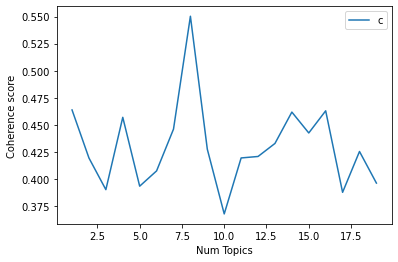

Num Topics = 1  has Coherence Value of 0.4638
Num Topics = 2  has Coherence Value of 0.4195
Num Topics = 3  has Coherence Value of 0.3903
Num Topics = 4  has Coherence Value of 0.457
Num Topics = 5  has Coherence Value of 0.3935
Num Topics = 6  has Coherence Value of 0.4076
Num Topics = 7  has Coherence Value of 0.4461
Num Topics = 8  has Coherence Value of 0.5503
Num Topics = 9  has Coherence Value of 0.4276
Num Topics = 10  has Coherence Value of 0.3679
Num Topics = 11  has Coherence Value of 0.4195
Num Topics = 12  has Coherence Value of 0.4209
Num Topics = 13  has Coherence Value of 0.4329
Num Topics = 14  has Coherence Value of 0.4618
Num Topics = 15  has Coherence Value of 0.4426
Num Topics = 16  has Coherence Value of 0.463
Num Topics = 17  has Coherence Value of 0.3878
Num Topics = 18  has Coherence Value of 0.4255
Num Topics = 19  has Coherence Value of 0.3963


In [22]:
# Can take a long time to run.
coherence_list, model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=1, limit=20,step=1)

In [23]:
# Select the model and print the topics
optimal_model = model_list[get_model_index(model_list)][1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))


[(0,
  '0.035*"python" + 0.030*"building" + 0.025*"home" + 0.020*"day" + '
  '0.020*"scratch" + 0.019*"graduate" + 0.017*"result" + 0.017*"forum" + '
  '0.017*"holiday" + 0.016*"year"'),
 (1,
  '0.030*"news" + 0.026*"learn" + 0.026*"course" + 0.015*"python" + '
  '0.010*"neural" + 0.008*"cloud" + 0.008*"machine" + 0.007*"solve" + '
  '0.007*"datum" + 0.007*"twitter"'),
 (2,
  '0.004*"franklin" + 0.004*"nuclear" + 0.004*"resist" + 0.004*"vulnerable" + '
  '0.004*"dragon" + 0.004*"destruction" + 0.004*"march" + 0.004*"jeff" + '
  '0.004*"double" + 0.001*"relatively"'),
 (3,
  '0.038*"minute" + 0.035*"read" + 0.035*"news" + 0.031*"time" + 0.028*"free" '
  '+ 0.027*"worth" + 0.023*"week" + 0.022*"hour" + 0.021*"medium" + '
  '0.020*"learn"'),
 (4,
  '0.012*"line" + 0.011*"social" + 0.009*"product" + 0.008*"minimum" + '
  '0.008*"viable" + 0.008*"platform" + 0.007*"sell" + 0.007*"safe" + '
  '0.007*"hash" + 0.006*"stack"'),
 (5,
  '0.049*"learn" + 0.032*"news" + 0.030*"course" + 0.025*"read

In [24]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.280888  0.072958       1        1  54.448960
5     -0.195679 -0.071153       2        1  33.057063
1     -0.005814 -0.124219       3        1   8.680799
0      0.071722  0.203151       4        1   2.328465
4      0.127655 -0.032679       5        1   1.123132
7      0.100662 -0.017600       6        1   0.253798
2      0.093260 -0.015851       7        1   0.094085
6      0.089082 -0.014607       8        1   0.013698, topic_info=        Term        Freq       Total Category  logprob  loglift
74    python   78.000000   78.000000  Default  30.0000  30.0000
451    watch  100.000000  100.000000  Default  29.0000  29.0000
1397  medium  134.000000  134.000000  Default  28.0000  28.0000
53     learn  327.000000  327.000000  Default  27.0000  27.0000
14    course  229.000000  229.000000  Default  26.0000  26.0000
...      ...         ...         ...      ...      ...      ...
40      game    0.000979   44.136976   Topic8  -7.3569  -1.8202
42     happy    0.000979  121.901979   Topic8  -7.3569  -2.8361
710    excel    0.000979    4.734891   Topic8  -7.3569   0.4122
284       go    0.000979   38.541821   Topic8  -7.3569  -1.6846
1061    auto    0.000979    0.997977   Topic8  -7.3569   1.9691

[462 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1348      1  0.912459   abbey
1112      5  0.959359     age
3         1  0.642399      ai
3         4  0.321200      ai
426       1  0.968005    alan
...     ...       ...     ...
103       3  0.012637   worth
271       2  0.979793  writer
310       1  0.101710    year
310       2  0.788250    year
310       4  0.101710    year

[419 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 2, 1, 5, 8, 3, 7])

In [25]:
# Marking each email with topic
# from itertools import chain
# lda_corpus = optimal_model[corpus]

# all_topics=lda_model.get_document_topics(corpus)
# scores = list(chain(*[[score for topic_id,score in topic] for topic in [doc for doc in lda_corpus]]))

# threshold = sum(scores)/len(scores)

# all_topics_csr = gensim.matutils.corpus2csc(all_topics)
# all_topics_numpy = all_topics_csr.T.toarray()
# categorized_docs=[]

# for document in all_topics_numpy:
#     if max(document) > threshold:
#         categorized_docs.append(document.argmax())
#     else:
#         categorized_docs.append('Unmarked')

# email_dataset_bodies = email_bodies.assign(Topic = categorized_docs)

In [26]:
# email_dataset_bodies['Topic'].value_counts(dropna=False)